In [1]:
import torch
from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transforms = Compose([Resize((224, 224)), ToTensor()])
dataset = ImageFolder('../data/train/', transform=transforms)
train_dataloader = DataLoader(dataset, 128, True)

In [2]:
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
from model import ConvNet

model = ConvNet(filters=[(128, 3)]*5, width_dense=128, activation_conv=torch.nn.SiLU).to(device)
model.load_state_dict(torch.load('./models/[128, 128, 128, 128, 128]_filters_128_width__silu_2_poolsize_0.0001_lr_0.001_wd_bnorm_aug'))

<All keys matched successfully>

In [4]:
dataset_test = ImageFolder('../data/val/', transform=transforms)

In [5]:
full_dataloader = DataLoader(dataset_test, batch_size=len(dataset_test))
X_test, Y_test = next(iter(full_dataloader))
X_test.shape, Y_test.shape

(torch.Size([2000, 3, 224, 224]), torch.Size([2000]))

In [6]:
from model import predict

preds = predict(model, X_test, device=device)
preds.shape

torch.Size([2000, 10])

In [7]:
from metrics import CategoricalAccuracy

metric = CategoricalAccuracy()
score = metric(preds, Y_test)
score

tensor(0.4440)

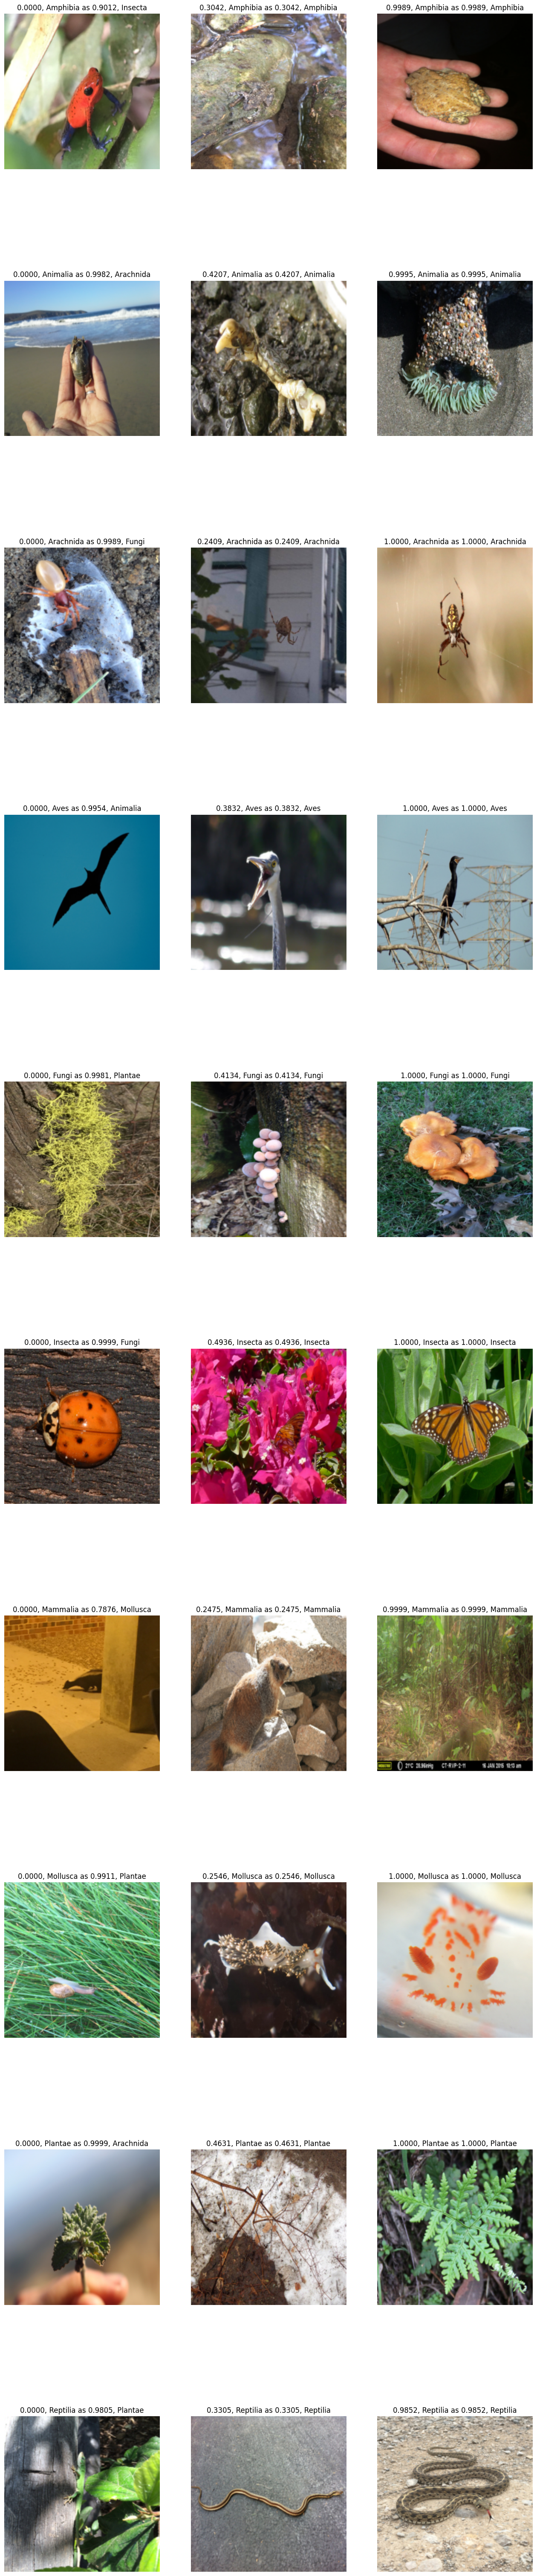

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 3, figsize=(16, 80))
CLASS_NAMES = dataset_test.classes

true_preds = preds.argmax(dim=1)
for i in range(10):
    X_sub, Y_sub, preds_sub, true_sub = X_test[Y_test==i], Y_test[Y_test==i], preds[Y_test==i][:, i], true_preds[Y_test==i]
    # print(preds_sub.min(), preds_sub[torch.abs(preds_sub - 0.5).argmin()], preds_sub.max())
    min_ind = preds_sub.argmin()
    max_ind = preds_sub.argmax()
    avg_ind = preds_sub[i == true_sub].argmin()
    INDS = [min_ind, avg_ind, max_ind]
    for j in range(3):
        if j != 1:
            ax[i][j].imshow(X_sub[INDS[j]].permute(1, 2, 0))
            ax[i][j].set_title(f'{preds_sub[INDS[j]].item():.4f}, {CLASS_NAMES[i]} as {preds[Y_test==i][INDS[j]].max():.4f}, {CLASS_NAMES[preds[Y_test==i][INDS[j]].argmax()]}')
        else:
            ax[i][j].imshow(X_sub[i == true_sub][INDS[j]].permute(1, 2, 0))
            ax[i][j].set_title(f'{preds_sub[i == true_sub][INDS[j]].item():.4f}, {CLASS_NAMES[i]} as {preds[Y_test==i][i == true_sub][INDS[j]].max():.4f}, {CLASS_NAMES[preds[Y_test==i][i == true_sub][INDS[j]].argmax()]}')
        ax[i][j].axis('off')


In [ ]:
import wandb
CLASS_NAMES = dataset_test.classes

true_preds = preds.argmax(dim=1)
for i in range(10):
    X_sub, Y_sub, preds_sub, true_sub = X_test[Y_test==i], Y_test[Y_test==i], preds[Y_test==i][:, i], true_preds[Y_test==i]
    min_ind = preds_sub.argmin()
    max_ind = preds_sub.argmax()
    avg_ind = preds_sub[i == true_sub].argmin()
    INDS = [min_ind, avg_ind, max_ind]
    for j in range(3):
        with wandb.init(project='CS6910-A2'):
            if j != 1:
                wandb.log({'test_images': wandb.Image(
                    X_sub[INDS[j]].permute(1, 2, 0).numpy(),
                    caption=f'{preds_sub[INDS[j]].item():.4f}, {CLASS_NAMES[i]} as {preds[Y_test==i][INDS[j]].max():.4f}, {CLASS_NAMES[preds[Y_test==i][INDS[j]].argmax()]}'            
                )})
            else:
                wandb.log({'test_images': wandb.Image(
                    X_sub[i == true_sub][INDS[j]].permute(1, 2, 0).numpy(),
                    caption=f'{preds_sub[i == true_sub][INDS[j]].item():.4f}, {CLASS_NAMES[i]} as {preds[Y_test==i][i == true_sub][INDS[j]].max():.4f}, {CLASS_NAMES[preds[Y_test==i][i == true_sub][INDS[j]].argmax()]}'            
                )})